# Autoencoder (for latent plotting)

In [7]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
from tqdm import tqdm
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Define Dataloaders

In [8]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/' 
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'
models_folder = parent_folder + 'wonglab-capstone/DotsTorch/Trained_models/'

class ArtKymoDataset(Dataset):
    def __init__(self):
        # Data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        # Mean centering to match artificial data
        for i, kymo in enumerate(kymos):
            kymo = np.divide(kymo,np.mean(kymo))
            kymos[i] = kymo
        kymos = torch.from_numpy(kymos)
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))
        kymos = kymos.astype('float32')
        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(1200, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 20, 60))
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def trainVAE(autoencoder, lr, data, epochs=10, tol = 1000, shuffle=False):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    data_len = len(data)
    past_loss = 0
    if shuffle:
        shuffle_index =  torch.randperm(len(data))
        for epoch in range(epochs):
            startTime = time.perf_counter()
            loss_count = 0
            MSE_count = 0
            KL_count = 0
            for i in shuffle_index:
                x = data[i]
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                #losses
                MSE_loss = ((x - x_hat)**2).sum()
                loss = MSE_loss 
                loss.backward()
                #counters
                loss_count += loss.item()
                # MSE_count += MSE_loss
                # KL_count += KL_loss
                opt.step()
            timediff = (time.perf_counter()-startTime)
            print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
            # print("\t \tMSE Loss: {:.3f} \tKL Divergence: {:.3f}".format(MSE_loss/data_len,KL_count/data_len))
            if abs(past_loss-loss_count) < tol:
                print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
                return autoencoder
            past_loss = loss_count
    return autoencoder

#### Train the semi-suss model (plots will look good :0)

In [11]:
data = ArtKymoDataset()
AE = Autoencoder(latent_dims=2)
epochs = 10

AE = trainVAE(AE, 1e-5, data, epochs = epochs, shuffle=True, tol=10)

	Epoch 1 complete 	Average Loss: 215.469 	Training time: 8.776 
	Epoch 2 complete 	Average Loss: 70.549 	Training time: 11.344 
	Epoch 3 complete 	Average Loss: 67.832 	Training time: 9.097 
	Epoch 4 complete 	Average Loss: 67.580 	Training time: 10.266 
	Epoch 5 complete 	Average Loss: 67.461 	Training time: 12.324 
	Epoch 6 complete 	Average Loss: 67.380 	Training time: 12.344 
	Epoch 7 complete 	Average Loss: 66.825 	Training time: 9.638 
	Epoch 8 complete 	Average Loss: 66.328 	Training time: 8.934 
	Epoch 9 complete 	Average Loss: 66.267 	Training time: 8.740 
	Epoch 10 complete 	Average Loss: 66.200 	Training time: 8.238 


In [20]:
def plot_latent(autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    plt.grid(color='gray', alpha=0.5)
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            plt.scatter(z[dims[0]], z[dims[1]], c='r', label = ('pol' if i == 101 else None))
        else:
            plt.scatter(z[dims[0]], z[dims[1]], c='navy', label = ('rand' if i == 201 else None))

    if exp_data != None:
        for i, z in enumerate(exp_data):
            z.reshape(1,20,60)
            z = autoencoder.encoder(z.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[dims[0]]+0.5, z[dims[1]]+0.7, c='g', label = ('Experimental' if i == 1 else None))

    plt.xlabel('Latent axis'.format(dims[0]))
    plt.ylabel('Latent axis {}'.format(dims[1]))
    #plt.legend(loc='upper left')
    plt.title('Latent Component Analysis')

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(3):
        idz = np.random.randint(i*100,i*100+100)
        print(idz)
        y = data[idz]
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(y[0,:,:], cmap='gray')
        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

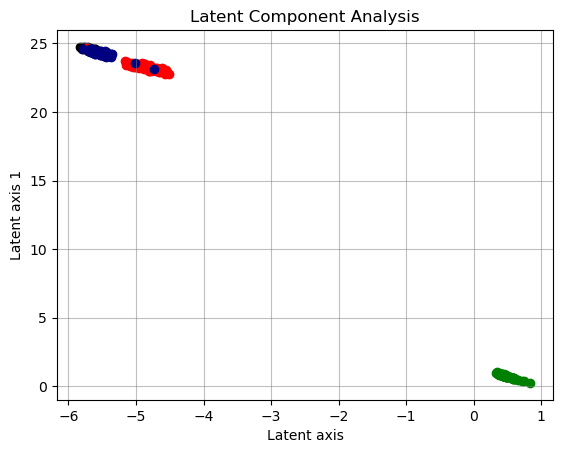

In [21]:
plot_latent(AE,data, dims=[0,1], exp_data=ExpKymoDataset())

18
189
287


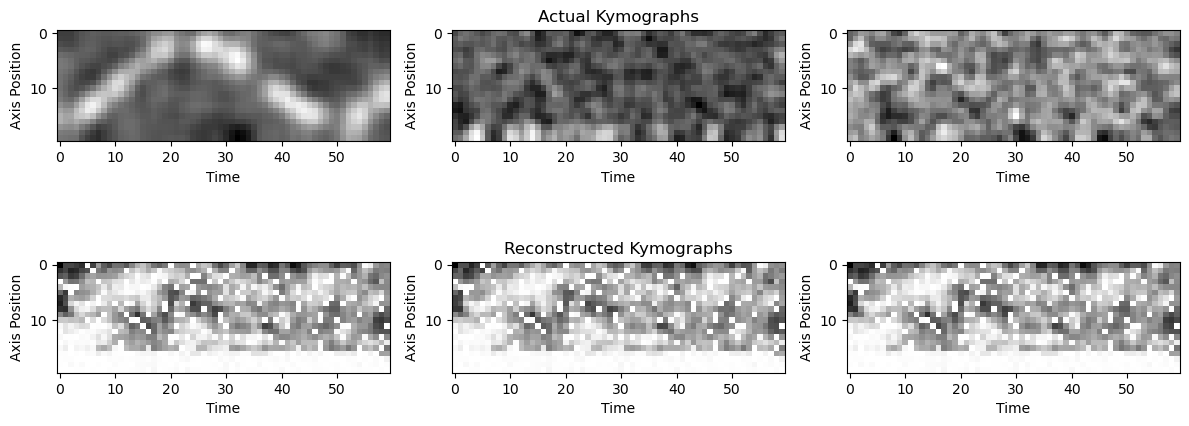

In [15]:
plot_sample_im(AE,data)

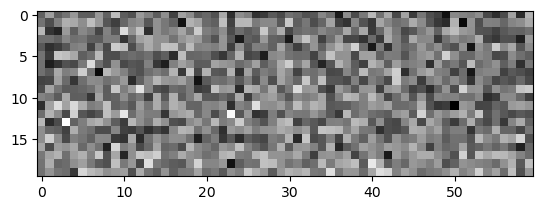

In [29]:
plt.imshow(AE(ExpKymoDataset()[0]).reshape(20,60).detach().numpy(), cmap='gray')

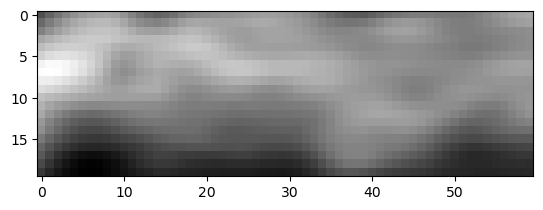

In [30]:
plt.imshow((ExpKymoDataset()[0]), cmap='gray')